In [1]:
import visual_behavior_glm.src.GLM_params as glm_params
import visual_behavior_glm.src.GLM_analysis_tools as gat
import visual_behavior_glm.src.GLM_visualization_tools as gvt
from visual_behavior_glm.src.glm import GLM
import matplotlib.pyplot as plt
import visual_behavior.data_access.loading as loading
import visual_behavior.database as db
import plotly.express as px

import pandas as pd
import numpy as np
import os

import seaborn as sns

import visual_behavior.plotting as vbp

import plotly.express as px
from sklearn.cluster import KMeans
import umap

/home/dougo/Code/AllenSDK/allensdk/brain_observatory/behavior/behavior_ophys_api/behavior_ophys_nwb_api.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
%matplotlib notebook
%widescreen
%standard_imports

applied a custom magic command to make full use of screen width
will only work if command is defined locally
replace with the following to replicate functionality: 
	from IPython.core.display import display, HTML
	display(HTML("<style>.container { width:100% !important; }</style>")
imported:
	os
	pandas as pd
	numpy as np
	matplotlib.pyplot as plt


# Gather/organize data

## load the results summary for a single GLM version from mongo

In [3]:
glm_version = '6_L2_optimize_by_session'
dropout_summary = gat.retrieve_results(search_dict = {'glm_version': glm_version}, results_type='summary')
dropout_summary.sample(5)

,_id,dropout,absolute_change_from_full,variance_explained,variance_explained_full,fraction_change_from_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,entry_time_utc
1350317,5f4fd79f0013a7f7e71986a8,visual,-4.581276e-03,0.074562,0.079144,-0.057886,1028830069,-0.057699,0.075229,0.079835,929655730,929255311,929341697,1026722873,VisualBehaviorMultiscope,completed,passed,20190822_453988_1imagesA,OPHYS_1_images_A,MESO.1,2019-08-22 08:21:33.000000,848974280,840355567,M,195.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",205,VISl,NaN,840355567,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISl_205,1,1,6_L2_optimize_by_session,2020-09-02 17:34:23.186463
138843,5f4fcfa4b8f0bff6c4d8f044,visual,-3.192600e-03,0.007530,0.010722,-0.297756,993886723,-0.296974,0.007556,0.010748,993863108,993669512,993706715,991913064,VisualBehaviorTask1B,holding,passed,20191211_491060_2ImagesB_retake,OPHYS_2_images_B_passive,CAM2P.3,2019-12-11 16:38:44.000000,972064221,962177507,M,118.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,962177507,Slc17a7-IRES2-Cre,NaN,NaN,0,0,Slc17a7_VISp_175,1,2,6_L2_optimize_by_session,2020-09-02 17:00:20.675080
1700525,5f4fd7cf9572a312da69fda6,false_alarms,6.499232e-07,0.082826,0.082826,0.000000,1028780691,0.000000,0.000000,0.000000,915243090,914639324,914705301,1018027878,VisualBehaviorMultiscope,completed,passed,20190731_453911_3imagesA_retake_2,OPHYS_3_images_A,MESO.1,2019-07-31 08:56:17.109568,848541804,840390377,M,173.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",181,VISp,NaN,840390377,Slc17a7-IRES2-Cre,NaN,"parent_averaged_depth_image_3,parent_averaged_...",2,1,Slc17a7_VISp_181,1,3,6_L2_optimize_by_session,2020-09-02 17:35:11.791849
2027974,5f5131d0d64efd09f7046ad2,image6,0.000000e+00,0.000000,0.000000,0.000000,1018094870,0.000000,0.000000,0.000000,882551937,882060185,882256127,1018028374,VisualBehaviorMultiscope,completed,passed,20190606_435431_Ophys3,OPHYS_3_images_A,MESO.1,2019-06-06 09:29:08.939495,815343876,807248992,M,202.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],270,VISp,NaN,807248992,Vip-IRES-Cre,NaN,NaN,0,1,Vip_VISp_270,0,3,6_L2_optimize_by_session,2020-09-03 18:11:28.019920
2751314,5f51a010993d290335a5c5f8,image6,-8.414313e-05,0.007413,0.007497,-0.011224,1007033794,-0.154838,0.005478,0.006482,936494970,935554523,935653479,930024022,VisualBehavior,container_qc,passed,20190830_459773_3imagesA,OPHYS_3_images_A,CAM2P.5,2019-08-30 15:56:52.000000,863334770,854612265,F,175.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",175,VISp,NaN,854612265,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_175,1,3,6_L2_optimize_by_session,2020-09-04 02:01:52.351703


In [4]:
all_dropouts = np.sort([dropout for dropout in dropout_summary['dropout'].unique() if not dropout.startswith('single')])
all_dropouts

array(['Full', 'all-images', 'beh_model', 'change', 'correct_rejects',
       'face_motion_energy', 'false_alarms', 'hits', 'image0', 'image1',
       'image2', 'image3', 'image4', 'image5', 'image6', 'image7',
       'image_expectation', 'intercept', 'misses', 'model_bias',
       'model_omissions1', 'model_task0', 'model_timing1D', 'omissions',
       'post_lick_bouts', 'post_licks', 'pre_lick_bouts', 'pre_licks',
       'pupil', 'rewards', 'running', 'time', 'visual'], dtype='<U18')

In [5]:
dropout_summary_pivoted = gat.build_pivoted_results_summary(results_summary=dropout_summary, cutoff=0.01, value_to_use='adj_fraction_change_from_full')

## load the behavior model weights

In [6]:
behavior_model_summary = loading.get_behavior_model_summary_table()
behavior_model_summary.sample(10)

,behavior_session_id,ophys_session_id,ophys_experiment_id,project_code,session_type,equipment_name,date_of_acquisition,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,cre_line,donor_id,active,imaging_depth,container_id,image_set,trained_A,trained_B,stage,good,num_hits,num_fa,num_cr,num_miss,num_aborts,session_roc,lick_fraction,lick_fraction_1st,lick_fraction_2nd,lick_hit_fraction,lick_hit_fraction_1st,lick_hit_fraction_2nd,trial_hit_fraction,trial_hit_fraction_1st,trial_hit_fraction_2nd,task_dropout_index,task_only_dropout_index,timing_only_dropout_index,prior_bias,avg_weight_bias,avg_weight_bias_1st,avg_weight_bias_2nd,prior_omissions1,avg_weight_omissions1,avg_weight_omissions1_1st,avg_weight_omissions1_2nd,prior_task0,avg_weight_task0,avg_weight_task0_1st,avg_weight_task0_2nd,prior_timing1D,avg_weight_timing1D,avg_weight_timing1D_1st,avg_weight_timing1D_2nd,task_weight_index,task_weight_index_1st,task_weight_index_2nd,task_session,container_in_order,full_container,meso
225,848613406,848264483,[848697625],VisualBehavior,OPHYS_1_images_A,CAM2P.3,2019-04-09 17:15:25.000000,820878213,M,97.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",Slc17a7-IRES2-Cre,820878203,True,375.0,846215539.0,A,True,False,1,True,147.0,6.0,29.0,84.0,373.0,0.822950,0.118640,0.145756,0.092788,0.278937,0.294304,0.255924,0.636364,0.885714,0.428571,7.807193,-13.596332,-5.789139,0.085004,-2.470511,-2.002368,-2.916831,0.017336,1.674556,1.787847,1.566547,0.041780,3.219019,3.716149,2.745062,0.067120,1.362656,2.367810,0.404357,1.856362,1.348339,2.340705,True,True,True,NaN
35,883696092,883509540,[884221469],VisualBehavior,OPHYS_1_images_A,CAM2P.4,2019-06-10 17:15:25.000000,843387586,F,110.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,['Ai94(TITL-GCaMP6s)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",Slc17a7-IRES2-Cre,843387577,True,175.0,902748564.0,A,True,False,1,True,51.0,4.0,39.0,258.0,308.0,0.680557,0.080871,0.059105,0.103636,0.140110,0.191176,0.109649,0.165049,0.155689,0.176056,-1.597009,-0.274045,-1.871054,0.057262,-2.650074,-2.979129,-2.305912,0.021047,-0.080461,0.306795,-0.485496,0.015302,0.628157,0.912290,0.330980,0.146234,1.591433,1.344629,1.849567,-0.963276,-0.432340,-1.518587,False,False,True,NaN
85,920839478,920695792,[921024187 921024189 921024191 921024193 92102...,VisualBehaviorMultiscope,OPHYS_4_images_B,MESO.1,2019-08-09 12:55:56.000000,840544752,M,182.0,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Vip-IRES-Cre'],Vip-IRES-Cre,840544745,True,NaN,NaN,NaN,NaN,NaN,4,True,56.0,2.0,28.0,165.0,448.0,0.907376,0.114497,0.224858,0.015711,0.109589,0.090717,0.351351,0.253394,0.860000,0.076023,-14.181699,-4.310464,-18.492163,0.100589,-2.553967,-0.268762,-4.599492,0.040203,0.568408,1.303597,-0.089672,0.094383,2.454677,2.122642,2.751888,0.210199,0.471856,4.053688,-2.734301,1.982821,-1.931046,5.486189,False,NaN,NaN,True
68,855866701,855762043,[856096766],VisualBehavior,OPHYS_6_images_B,CAM2P.3,2019-04-23 16:57:21.000000,820871408,M,110.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",Slc17a7-IRES2-Cre,820871399,True,375.0,845588020.0,B,True,False,6,True,71.0,3.0,28.0,143.0,408.0,0.816590,0.115274,0.083333,0.150100,0.147917,0.171271,0.133779,0.331776,0.236641,0.481928,-11.834199,-0.882432,-12.716632,0.065051,-2.169976,-2.624674,-1.674191,0.022469,0.748605,0.384141,1.146003,0.000957,1.044286,1.043707,1.044918,0.294271,1.761466,0.442487,3.199630,-0.717180,0.601219,-2.154711,False,False,True,NaN
65,989062361,988903485,[989212488 989212489 989212491 989212492 98921...,VisualBehaviorMultiscope,OPHYS_6_images_B,MESO.1,2019-11-21 10:49:05.550125,904922342,F,172.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],Sst-IRES-Cre,904922330,True,NaN,NaN,NaN,NaN,NaN,6,True,89.0,6.0,37.0,209.0,220.0,0.869522,0.070744,0.133070,0.017000,0.287097,0.281481,0

In [7]:
fig,ax=plt.subplots()
ax.hist(behavior_model_summary['task_dropout_index'])
ax.set_xlabel('task_dropout_index')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'task_dropout_index')

## get the dominant dropout for each cell in each session

In [8]:
def get_dominant_dropout(row, cols_to_check):
    return row[cols_to_check].astype(float).idxmin()

cols_to_check = [col for col in all_dropouts if not col.startswith('image') and col!='visual']
dropout_summary_pivoted['dominant_dropout'] = dropout_summary_pivoted.apply(get_dominant_dropout, axis=1, args=[cols_to_check])

In [9]:
row = dropout_summary_pivoted.iloc[20]
row[cols_to_check].astype(float).idxmin()

'omissions'

In [10]:
dropout_summary_pivoted['dominant_dropout'].unique()

array(['omissions', 'all-images', 'running', 'pupil', 'time',
       'face_motion_energy', 'correct_rejects', 'false_alarms', 'misses',
       'intercept', 'post_lick_bouts', 'post_licks', 'pre_licks',
       'pre_lick_bouts', 'change', 'rewards', 'model_omissions1',
       'beh_model', 'hits', 'model_task0', 'model_bias', 'model_timing1D'],
      dtype=object)

## merge in task dropout index

In [11]:
dropout_summary_pivoted = dropout_summary_pivoted.merge(
    behavior_model_summary[['ophys_session_id','task_dropout_index']],
    left_on = 'ophys_session_id',
    right_on = 'ophys_session_id',
    how='left'
)

In [12]:
dropout_summary_pivoted.sample(10)

,identifier,Full,all-images,beh_model,change,correct_rejects,face_motion_energy,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,single-all-images,single-beh_model,single-change,single-correct_rejects,single-face_motion_energy,single-false_alarms,single-hits,single-image0,single-image1,single-image2,single-image3,single-image4,single-image5,single-image6,single-image7,single-image_expectation,single-misses,single-model_bias,single-model_omissions1,single-model_task0,single-model_timing1D,single-omissions,single-post_lick_bouts,single-post_licks,single-pre_lick_bouts,single-pre_licks,single-pupil,single-rewards,single-running,single-time,single-visual,time,visual,variance_explained_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,dominant_dropout,task_dropout_index
1770243,974433390_1028808153,0.0,-0.166545,-0.048401,0.000000,0.000000,0.000000,0.000000,0.000000,-0.142472,-0.194049,-0.049812,0.000000,-0.176138,-0.146212,-0.059279,-0.076596,-0.037731,0.000000,0.000000,-0.006587,0.0,0.000000,-0.025971,-0.106321,-0.127459,-0.086592,-0.008522,0.000000,0.000000,-0.031948,0.000000,-0.479492,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-0.477678,-0.660363,0.000000,0.000000,-0.491436,-0.589403,-0.320023,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,-0.659825,-0.698434,0.000000,0.000000,-0.458453,0.000000,0.000000,0.0,-0.522327,-0.000195,-0.209351,0.014234,1028808153,-0.106321,0.013503,0.015109,974433390,973384292,973440813,1018027825,VisualBehaviorMultiscope,completed,passed,20191028_484627_Ophys3_retake,OPHYS_3_images_A,MESO.1,2019-10-28 11:25:52.964945,943395690,930825455,M,112.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",183,VISp,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_183,0,3,6_L2_optimize_by_session,all-images,-0.468705
1819210,974994097_1028808099,0.0,-0.815356,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002587,-0.938814,0.000000,0.000000,-0.247462,-0.566222,-0.672044,0.000000,-0.959190,-0.018210,-0.004271,0.000000,0.000000,0.0,0.000000,0.000000,-0.025094,-0.024680,-0.000695,-0.007839,0.000000,-0.001850,-0.010585,0.000000,-0.955385,0.0,0.000000,0.000000,0.000000,0.0,-0.121808,-1.000000,0.000000,0.000000,-1.000000,-0.894050,-0.958253,0.000000,-1.000000,-0.151277,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.227675,0.000000,0.000000,-0.127685,-0.134765,0.000000,0.0,-0.963283,-0.001976,-0.826012,0.060603,1028808099,0.000000,0.001743,0.060603,974994097,974486549,974634733,1018027825,VisualBehaviorMultiscope,completed,passed,20191031_484627_Ophys6,OPHYS_6_images_B,MESO.1,2019-10-31 08:26:06.328780,943395690,930825455,M,115.0,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,['Ai93(TITL-GCaMP6f)'],"['Camk2a-tTA', 'Slc17a7-IRES2-Cre']",183,VISp,NaN,930825455,Slc17a7-IRES2-Cre,NaN,NaN,0,1,Slc17a7_VISp_183,0,6,6_L2_optimize_by_session,all-images,15.731729
1271386,942596349_1028835974,0.0,-0.021881,-0.014070,0.000000,-0.080060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.355271,-0.004733,-0.130216,0.000000,0.000000,0.0,-0.098784,0.000000,-0.450984,0.000000,0.000000,-0.038988,-0.064913,-0.143750,0.000000,-0.023077,-0.210812,0.0,-1.000000,-0.112977,0.000000,0.0,-0.411545,0.000000,-0.267178,0.0000

## add a `session_id` column with a numeric value for the session_type (to lump together sessions by order, regardless of image set)

In [13]:
def map_session_types(session_type):
    session_id = int(session_type[6:7])
    return session_id
dropout_summary_pivoted['session_id'] = dropout_summary_pivoted['session_type'].map(lambda st:map_session_types(st))

dropout_summary_pivoted

,identifier,Full,all-images,beh_model,change,correct_rejects,face_motion_energy,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,single-all-images,single-beh_model,single-change,single-correct_rejects,single-face_motion_energy,single-false_alarms,single-hits,single-image0,single-image1,single-image2,single-image3,single-image4,single-image5,single-image6,single-image7,single-image_expectation,single-misses,single-model_bias,single-model_omissions1,single-model_task0,single-model_timing1D,single-omissions,single-post_lick_bouts,single-post_licks,single-pre_lick_bouts,single-pre_licks,single-pupil,single-rewards,single-running,single-time,single-visual,time,visual,variance_explained_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,dominant_dropout,task_dropout_index,session_id
0,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.0,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.0,0.0,-0.666553,0.000000,-0.210558,0.070881,1003146172,0.000000,0.070881,0.070881,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session,omissions,-12.176364,1
1,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.0,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.0,0.0,-0.666553,0.000000,-0.210558,0.070881,1003146172,-0.136583,0.061420,0.071136,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session,omissions,-12.176364,1
2,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.0,-0.699134,-0.709555,-0.597968,-0.494895,-0.224

In [14]:
list(dropout_summary_pivoted.columns)

['identifier',
 'Full',
 'all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'face_motion_energy',
 'false_alarms',
 'hits',
 'image0',
 'image1',
 'image2',
 'image3',
 'image4',
 'image5',
 'image6',
 'image7',
 'image_expectation',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'single-all-images',
 'single-beh_model',
 'single-change',
 'single-correct_rejects',
 'single-face_motion_energy',
 'single-false_alarms',
 'single-hits',
 'single-image0',
 'single-image1',
 'single-image2',
 'single-image3',
 'single-image4',
 'single-image5',
 'single-image6',
 'single-image7',
 'single-image_expectation',
 'single-misses',
 'single-model_bias',
 'single-model_omissions1',
 'single-model_task0',
 'single-model_timing1D',
 'single-omissions',
 'single-post_lick_bouts',
 'single-post_licks',
 'single-pre_lick_bouts',
 

In [15]:
pd.options.display.max_rows = 250

In [16]:
dropout_summary_pivoted.groupby('cre_line')['dominant_dropout'].value_counts()

cre_line           dominant_dropout  
Slc17a7-IRES2-Cre  all-images            1352251
                   omissions              296415
                   running                114961
                   face_motion_energy      69270
                   pupil                   66685
                   correct_rejects         27455
                   post_lick_bouts         11593
                   pre_lick_bouts          11410
                   false_alarms             9480
                   post_licks               8644
                   beh_model                7355
                   rewards                  5583
                   hits                     4181
                   misses                   4038
                   change                   3764
                   time                     2909
                   model_omissions1         2189
                   model_timing1D           1621
                   model_task0              1450
                   model_bias  

In [17]:
dropout_summary_pivoted.equipment_name.unique()

array(['CAM2P.3', 'MESO.1', 'CAM2P.4', 'CAM2P.5'], dtype=object)

## Turn some categorical columns into numerical columns

In [18]:
def make_categorical(df, column):
    df['{}_categorical'.format(column)] = pd.Categorical(df[column], ordered=True).codes

for column in ['cre_line','equipment_name','targeted_structure','session_id','dominant_dropout']:
    make_categorical(dropout_summary_pivoted, column)
    
dropout_summary_pivoted

,identifier,Full,all-images,beh_model,change,correct_rejects,face_motion_energy,false_alarms,hits,image0,image1,image2,image3,image4,image5,image6,image7,image_expectation,intercept,misses,model_bias,model_omissions1,model_task0,model_timing1D,omissions,post_lick_bouts,post_licks,pre_lick_bouts,pre_licks,pupil,rewards,running,single-all-images,single-beh_model,single-change,single-correct_rejects,single-face_motion_energy,single-false_alarms,single-hits,single-image0,single-image1,single-image2,single-image3,single-image4,single-image5,single-image6,single-image7,single-image_expectation,single-misses,single-model_bias,single-model_omissions1,single-model_task0,single-model_timing1D,single-omissions,single-post_lick_bouts,single-post_licks,single-pre_lick_bouts,single-pre_licks,single-pupil,single-rewards,single-running,single-time,single-visual,time,visual,variance_explained_full,cell_specimen_id,adj_fraction_change_from_full,adj_variance_explained,adj_variance_explained_full,ophys_experiment_id,ophys_session_id,behavior_session_id,container_id,project_code,container_workflow_state,experiment_workflow_state,session_name,session_type,equipment_name,date_of_acquisition,isi_experiment_id,specimen_id,sex,age_in_days,full_genotype,reporter_line,driver_line,imaging_depth,targeted_structure,published_at,super_container_id,cre_line,session_tags,failure_tags,exposure_number,model_outputs_available,location,has_events,session_number,glm_version,dominant_dropout,task_dropout_index,session_id,cre_line_categorical,equipment_name_categorical,targeted_structure_categorical,session_id_categorical,dominant_dropout_categorical
0,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.0,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.0,0.0,-0.666553,0.000000,-0.210558,0.070881,1003146172,0.000000,0.070881,0.070881,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session,omissions,-12.176364,1,1,0,3,0,13
1,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-0.638035,0.0,-0.575072,-0.068230,-0.249255,-0.078913,-0.556801,-0.601904,-0.508371,-0.283021,-0.457283,0.0,-0.699134,-0.709555,-0.597968,-0.494895,-0.224524,0.0,0.0,0.0,0.0,-0.502804,-0.261601,-0.092529,-0.163023,-0.117406,-0.172257,-0.307221,0.0,0.0,-0.666553,0.000000,-0.210558,0.070881,1003146172,-0.136583,0.061420,0.071136,1000743008,1000580083,1000600602,999191979,VisualBehaviorTask1B,holding,passed,20200116_489056_1imagesB,OPHYS_1_images_B,CAM2P.3,2020-01-16 18:49:41.000000,962029605,951667115,M,165.0,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,['Ai148(TIT2L-GC6f-ICL-tTA2)'],['Sst-IRES-Cre'],275,VISp,NaN,951667115,Sst-IRES-Cre,NaN,NaN,0,1,Sst_VISp_275,0,1,6_L2_optimize_by_session,omissions,-12.176364,1,1,0,3,0,13
2,1000743008_1003146172,0.0,-0.136583,-0.003512,-0.020345,-0.023242,-0.044587,-0.045372,-0.008406,-0.039902,-0.003730,0.00000,-0.006323,0.000000,-0.040977,-0.195053,-0.039067,-0.026650,-0.002311,-0.052186,-0.002564,-0.000269,-0.000234,0.0,-0.176834,0.0,-0.015317,0.0,0.0,-0.012748,-0.01587,-0.005225,-

In [19]:
dropout_summary_pivoted['session_number'].unique()

array([1, 5, 2, 3, 4, 6])

## category == -1 represents None, set it to NaN

In [20]:
np.sort(dropout_summary_pivoted['dominant_dropout_categorical'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int8)

In [21]:
dropout_summary_pivoted.loc[dropout_summary_pivoted.query('dominant_dropout_categorical == -1').index,'dominant_dropout_categorical'] = np.nan

## merge in some columns from the original response_summary

In [36]:
dominant_dropout_matrix = (
    dropout_summary_pivoted
    .drop_duplicates(['cell_specimen_id','session_id'])
    .pivot(index='cell_specimen_id',columns='session_id',values='dominant_dropout_categorical')
    .rename(columns={k:'session_{}'.format(k) for k in dropout_summary_pivoted['session_id'].unique()})
)

cols_to_merge = [
    'cell_specimen_id',
    'cre_line',
    'cre_line_categorical',
    'imaging_depth',
    'targeted_structure',
    'targeted_structure_categorical',
    'equipment_name',
    'equipment_name_categorical',
    'task_dropout_index',
]
dominant_dropout_matrix = dominant_dropout_matrix.merge(
    dropout_summary_pivoted[cols_to_merge],
    left_on='cell_specimen_id',
    right_on='cell_specimen_id',
    how='left',
).set_index('cell_specimen_id')
dominant_dropout_matrix

,session_1,session_2,session_3,session_4,session_5,session_6,cre_line,cre_line_categorical,imaging_depth,targeted_structure,targeted_structure_categorical,equipment_name,equipment_name_categorical,task_dropout_index
cell_specimen_id,,,,,,,,,,,,,,
817101743,NaN,NaN,13.0,0.0,NaN,13.0,Vip-IRES-Cre,2,175,VISp,3,CAM2P.4,1,-12.645683
817101743,NaN,NaN,13.0,0.0,NaN,13.0,Vip-IRES-Cre,2,175,VISp,3,CAM2P.4,1,-12.645683
817101743,NaN,NaN,13.0,0.0,NaN,13.0,Vip-IRES-Cre,2,175,VISp,3,CAM2P.4,1,-12.645683
817101743,NaN,NaN,13.0,0.0,NaN,13.0,Vip-IRES-Cre,2,175,VISp,3,CAM2P.4,1,-12.645683
817101743,NaN,NaN,13.0,0.0,NaN,13.0,Vip-IRES-Cre,2,175,VISp,3,CAM2P.4,1,-12.645683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028894573,NaN,NaN,NaN,2.0,NaN,NaN,Vip-IRES-Cre,2,75,VISl,2,MESO.1,3,-15.842164
1028894573,NaN,NaN,NaN,2.0,NaN,NaN,Vip-IRES-Cre,2,75,VISl,2,MESO.1,3,-15.842164
1028894573,NaN,NaN,NaN,2.0,NaN,NaN,Vip-IRES-Cre,2,75,VISl,2,MESO.1,3,-15.842164


## define plot/heatmap parameters

In [37]:
# make sure there's a heatmap definition for every column, otherwise the column will plot without a heatmap!
cols_to_plot = [
    'session_1',
    'session_2',
    'session_3',
    'session_4',
    'session_5',
    'session_6',
    'cre_line_categorical',
    'targeted_structure_categorical',
    'imaging_depth',
    'equipment_name_categorical',
    'task_dropout_index'
]
heatmap_defs = [
    {
        'columns':['session_{}'.format(i) for i in [1,2,3,4,5,6]],
        'cbar_label':'dominant_dropout',
        'cbar_ticks':np.arange(len(dropout_summary_pivoted['dominant_dropout'].unique())),
        'cbar_ticklabels':np.sort([c for c in dropout_summary_pivoted['dominant_dropout'].unique() if pd.notnull(c)]),
        'vmin':-0.5,
        'vmax':len(dropout_summary_pivoted['dominant_dropout'].unique())-0.5,
        'cmap':sns.color_palette("Dark2", len(dropout_summary_pivoted['dominant_dropout'].unique())),
    },
    {
        'columns':['cre_line_categorical'],
        'cbar_label':'cre_line',
        'cbar_ticks':[0,1,2],
        'cbar_ticklabels':np.sort(np.unique(dropout_summary_pivoted['cre_line'])),
        'vmin':-0.5,
        'vmax':2.5,
        'cmap':sns.color_palette("hls", 3),
    },
    {
        'columns':['equipment_name_categorical'],
        'cbar_label':'equipment name',
        'cbar_ticks':np.arange(len(np.unique(dropout_summary_pivoted['equipment_name']))),
        'cbar_ticklabels':np.sort(np.unique(dropout_summary_pivoted['equipment_name'])),
        'vmin':-0.5,
        'vmax':len(np.unique(dropout_summary_pivoted['equipment_name']))-0.5,
        'cmap':sns.color_palette("hls", len(np.unique(dropout_summary_pivoted['equipment_name']))),
    },
    {
        'columns':['targeted_structure_categorical'],
        'cbar_label':'targeted structure',
        'cbar_ticks':np.arange(len(dropout_summary_pivoted['targeted_structure_categorical'].unique())),
        'cbar_ticklabels':np.sort(np.unique(dropout_summary_pivoted['targeted_structure'])),
        'vmin':-0.5,
        'vmax':len(dropout_summary_pivoted['targeted_structure'].unique())-0.5,
        'cmap':sns.color_palette("hls", len(dropout_summary_pivoted['targeted_structure'].unique())),
    },
    {
        'columns':['imaging_depth'],
        'cbar_label':'imaging_depth',
        'cbar_ticks':[0,100,200,300,400],
        'vmin':0,
        'vmax':400,
        'cmap':'magma',
    },
    {
        'columns':['task_dropout_index'],
        'cbar_label':'task_dropout_index',
        'cbar_ticks':[-30,-20,-10,0,10,20,30],
        'vmin':-40,
        'vmax':40,
        'cmap':'RdBu',
    },
]

# plots

## Everything, sorted by cre-line, dropouts in sessions, depth

<IPython.core.display.Javascript object>


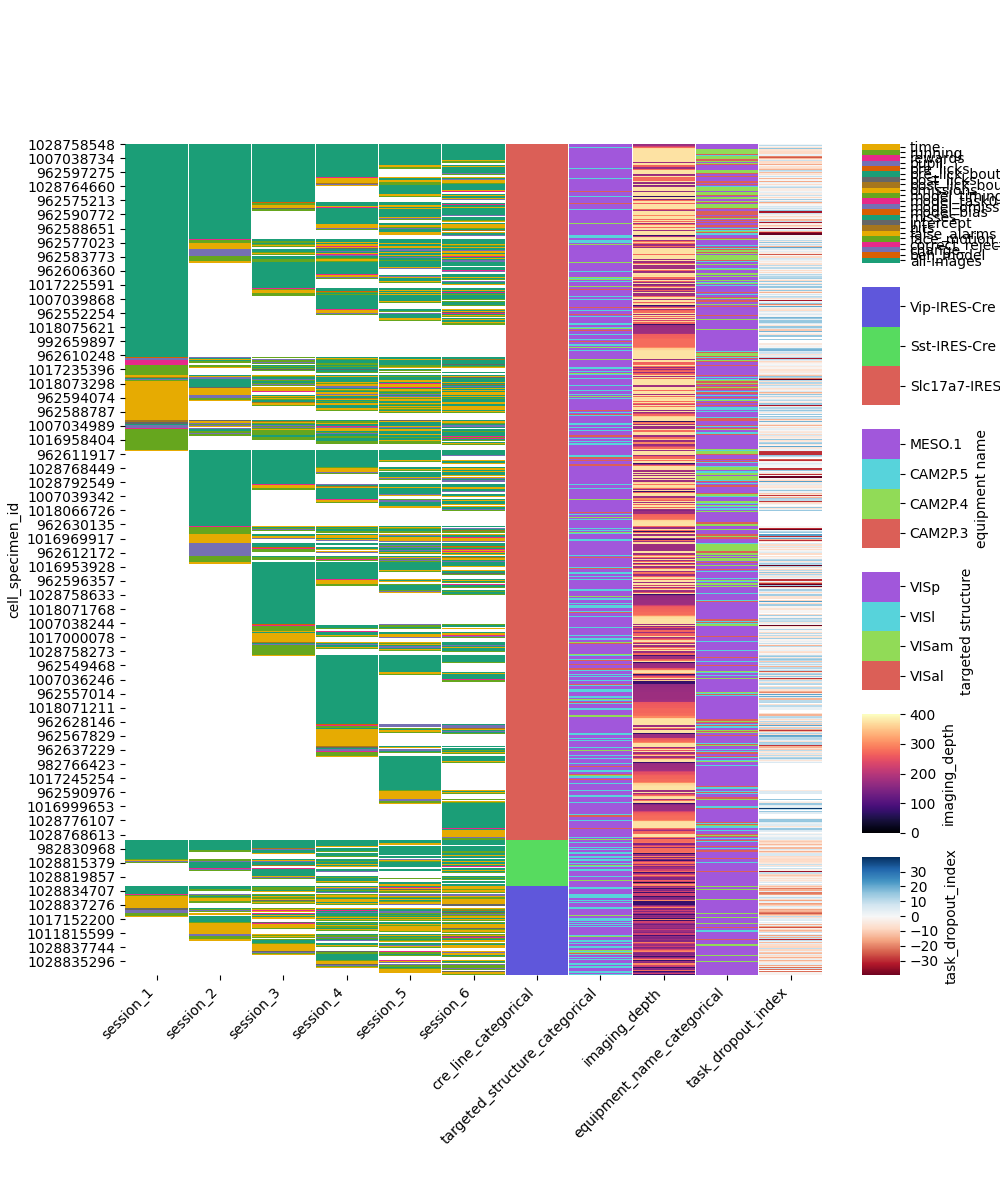

In [38]:
sort_by = [
    'cre_line_categorical',
    'session_1',
    'session_2',
    'session_3',
    'session_4',
    'session_5',
    'session_6',
    'imaging_depth'
]
data_to_plot = dominant_dropout_matrix[cols_to_plot].sort_values(by=sort_by)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=6, 
    heatmap_div=0.9, 
)

## only cells that are matched across all sessions, same sorting as above

<IPython.core.display.Javascript object>


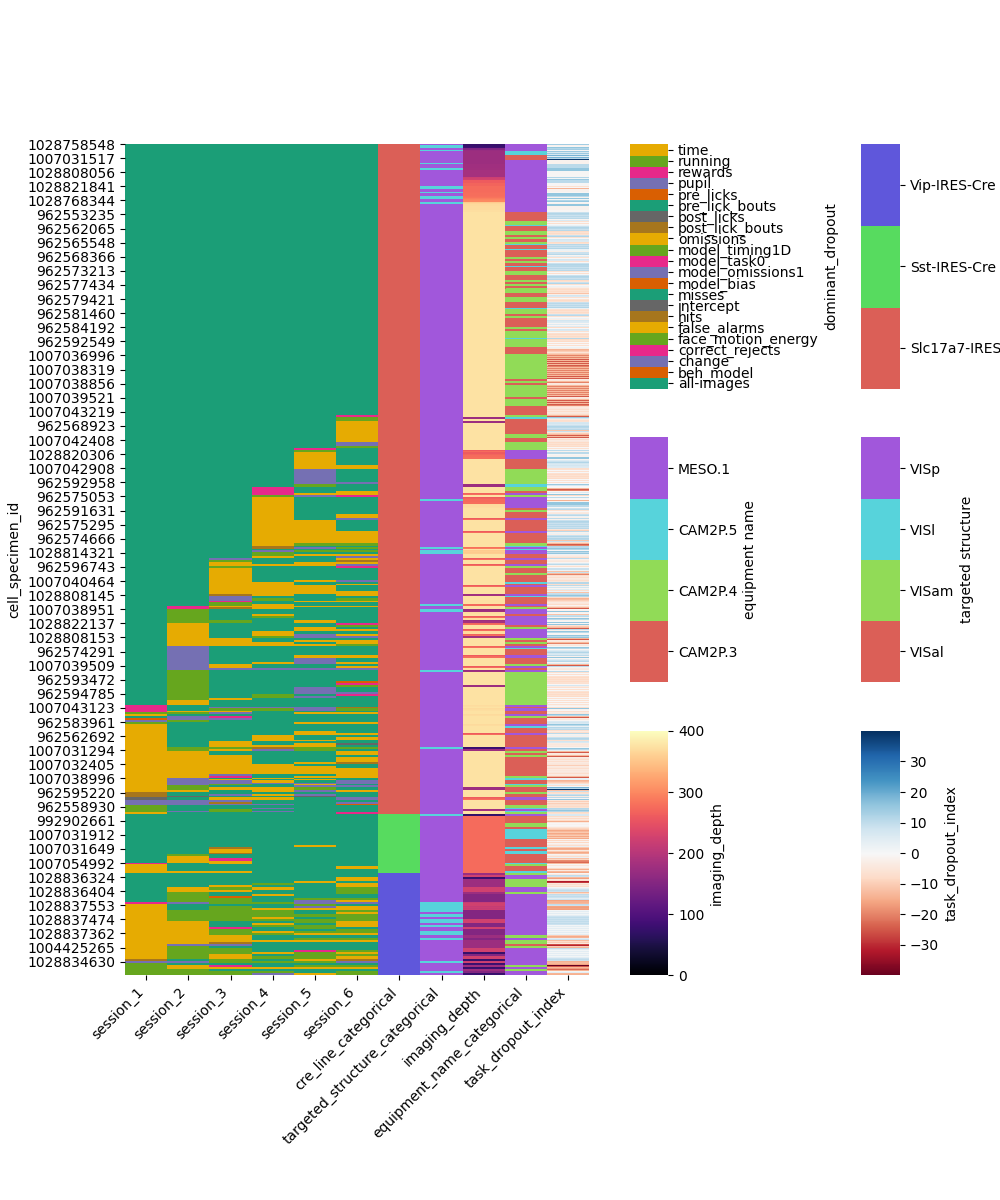

In [39]:
sort_by = [
    'cre_line_categorical',
    'session_1',
    'session_2',
    'session_3',
    'session_4',
    'session_5',
    'session_6',
    'imaging_depth'
]
data_to_plot = dominant_dropout_matrix[cols_to_plot].sort_values(by=sort_by).dropna()
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=3, 
    heatmap_div=0.6, 
)

<IPython.core.display.Javascript object>


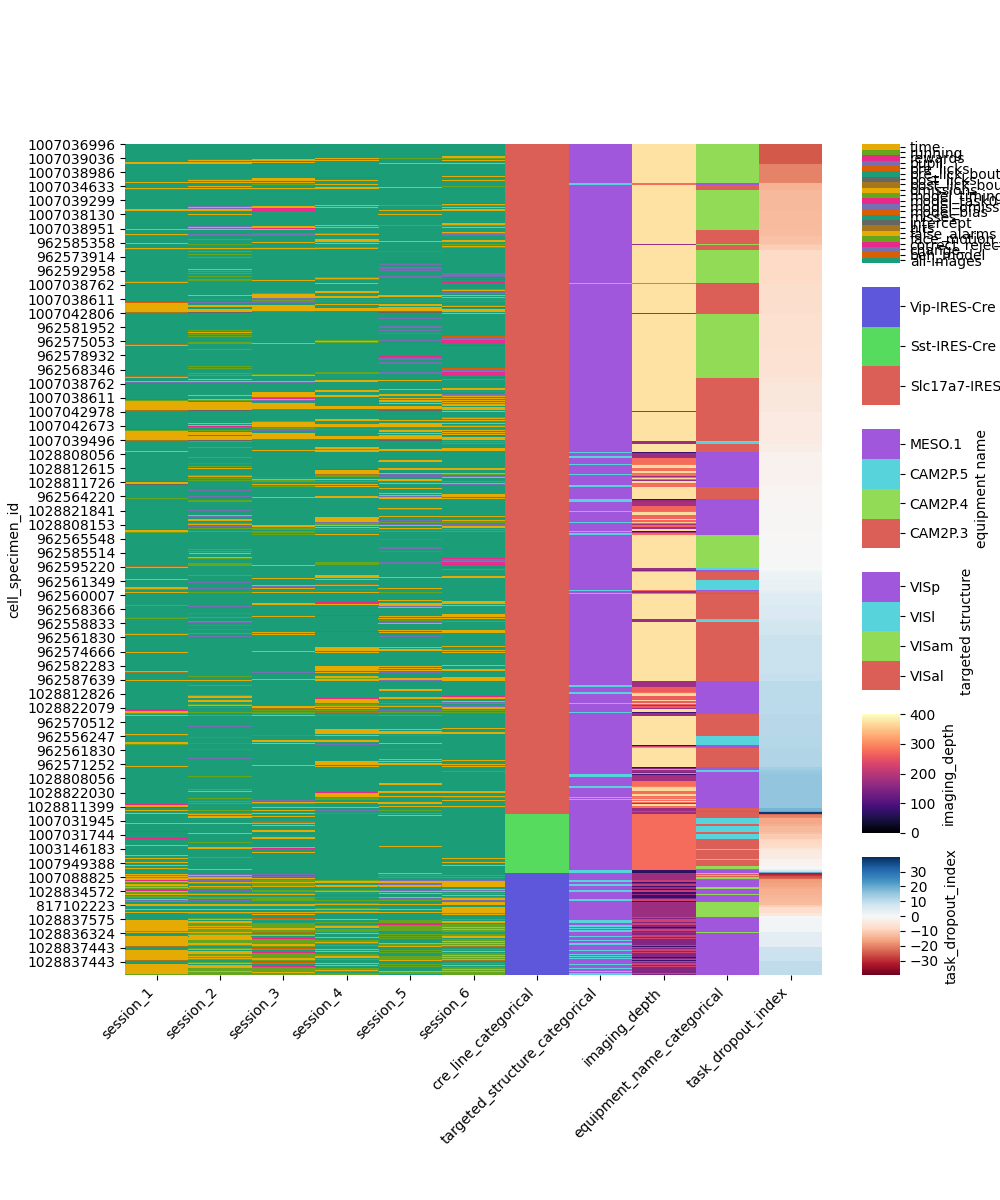

In [40]:
sort_by = [
    'cre_line_categorical',
    'task_dropout_index',
    'session_1',
    'session_3',
    'session_4',
    'session_6',
    'imaging_depth'
]
data_to_plot = dominant_dropout_matrix[cols_to_plot].sort_values(by=sort_by).dropna()
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=6, 
    heatmap_div=0.9, 
)

## exclude mesoscope sessions, only include cells matched across sessions

<IPython.core.display.Javascript object>


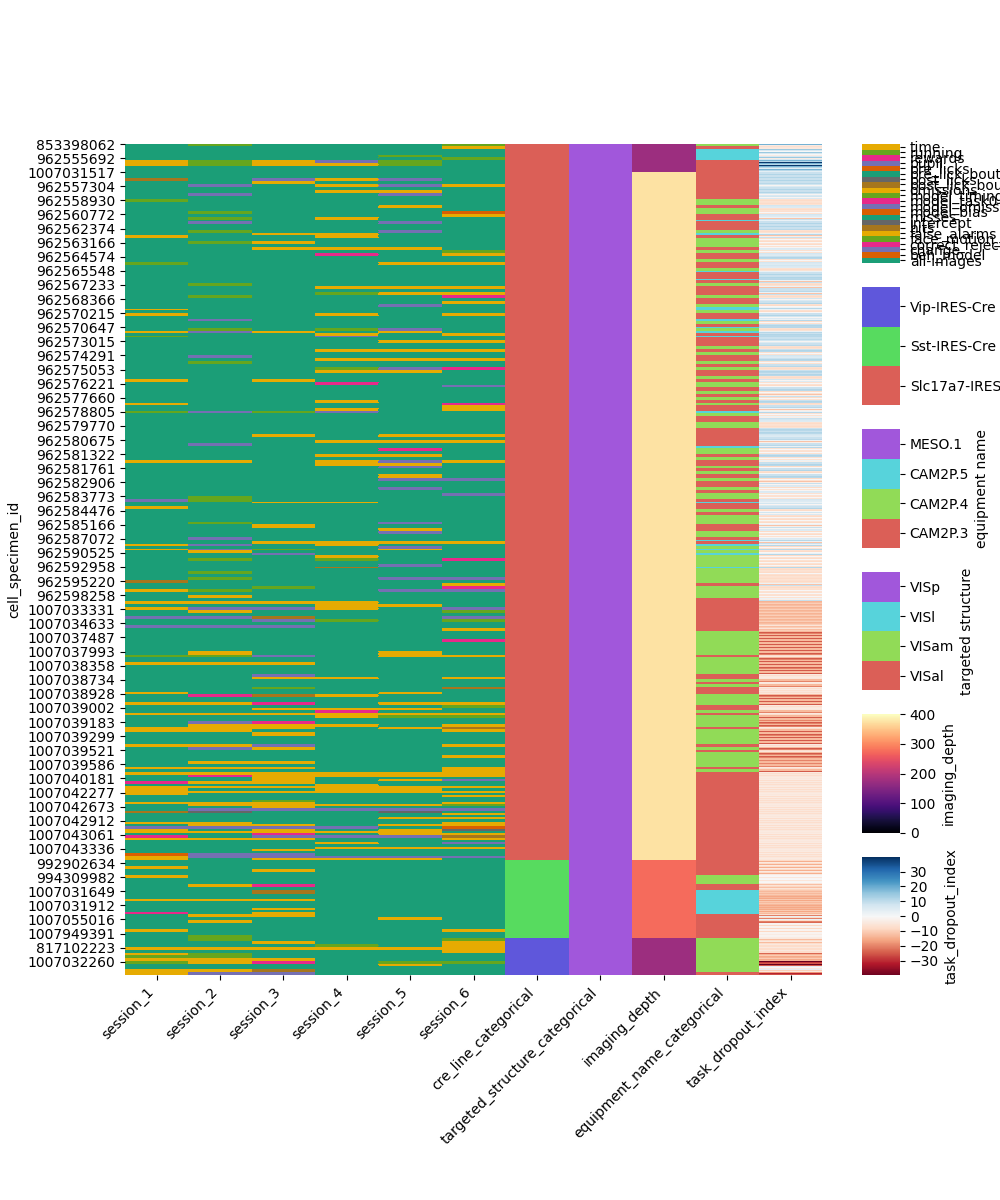

In [41]:
sort_by = [
    'cre_line_categorical',
    'imaging_depth'
]
data_to_plot = (
    dominant_dropout_matrix.query('equipment_name != "MESO.1"')[cols_to_plot]
    .sort_values(by=sort_by)
    .dropna()
)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=6, 
    heatmap_div=0.9, 
)

## sort only by cre-line and depth (still excluding mesoscope)

<IPython.core.display.Javascript object>


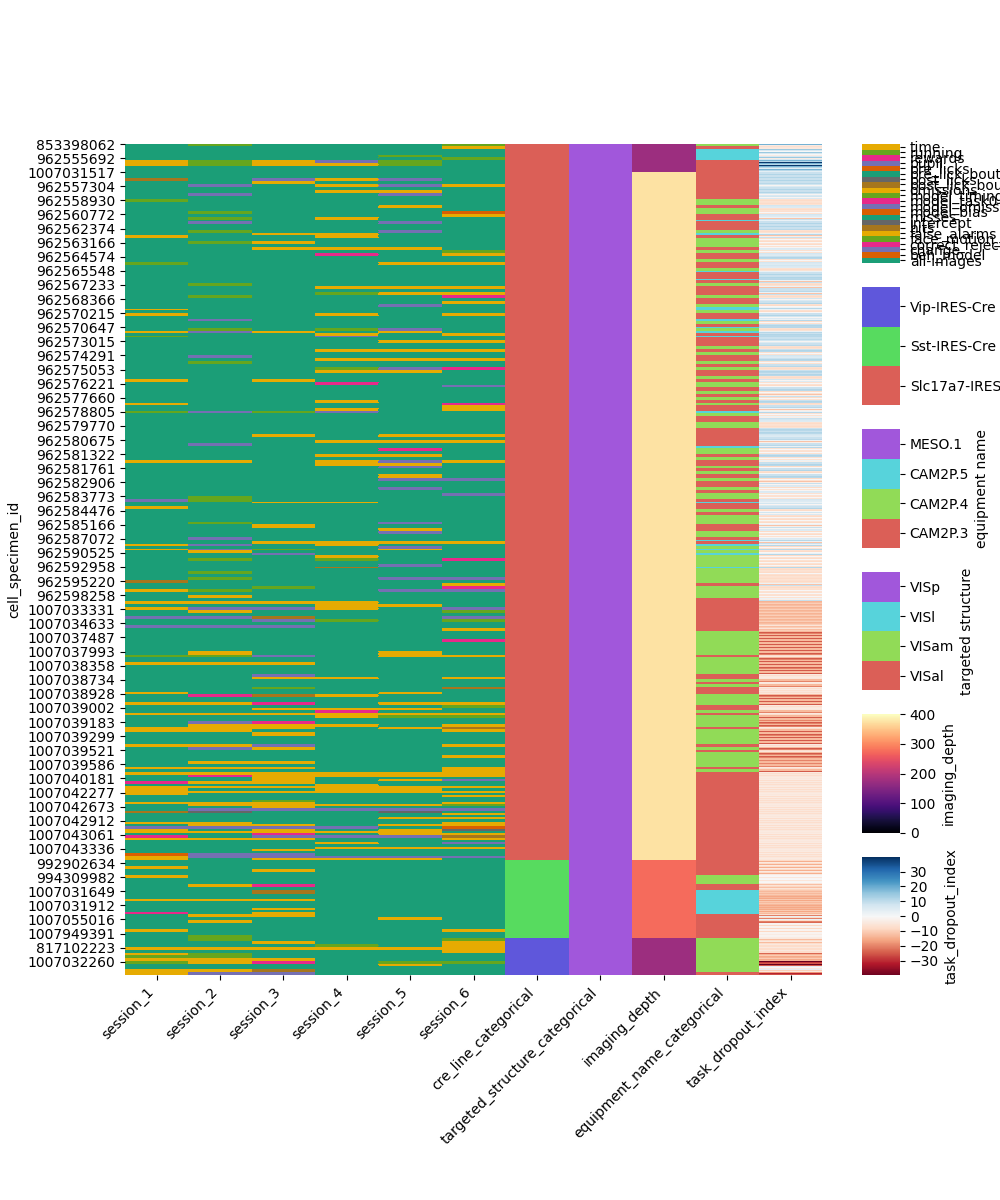

In [42]:
sort_by = [
    'cre_line_categorical',
    'imaging_depth',
]
data_to_plot = (
    dominant_dropout_matrix.query('equipment_name != "MESO.1"')[cols_to_plot]
    .sort_values(by=sort_by)
    .dropna()
)
fig, axes = vbp.make_multi_cmap_heatmap(
    data_to_plot, 
    heatmap_defs, 
    figsize=(10,12), 
    top_buffer=0, 
    bottom_buffer=0.1, 
    n_cbar_rows=6, 
    heatmap_div=0.9, 
)

## sankey plots

In [43]:
import plotly.graph_objects as go
import itertools

In [44]:
categories = list(np.sort([c for c in dropout_summary_pivoted['dominant_dropout'].unique() if pd.notnull(c)]))
categories

['all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'face_motion_energy',
 'false_alarms',
 'hits',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time']

In [45]:
categories = list(np.sort([c for c in dropout_summary_pivoted['dominant_dropout'].unique() if pd.notnull(c)]))
categories

['all-images',
 'beh_model',
 'change',
 'correct_rejects',
 'face_motion_energy',
 'false_alarms',
 'hits',
 'intercept',
 'misses',
 'model_bias',
 'model_omissions1',
 'model_task0',
 'model_timing1D',
 'omissions',
 'post_lick_bouts',
 'post_licks',
 'pre_lick_bouts',
 'pre_licks',
 'pupil',
 'rewards',
 'running',
 'time']

In [46]:
cre_lines = np.sort(dominant_dropout_matrix['cre_line'].unique())
cre_line = cre_lines[2]

In [47]:
# def sankey_diagram(data_to_plot, title_text=''):
data_to_plot = dominant_dropout_matrix.sort_values(by=sort_by).dropna().query('cre_line == "{}"'.format(cre_line))
title_text='Sankey plot, GLM verion = {}, cre_line = {}'.format(glm_version, cre_line)

def sankey_diagram(data_to_plot, title_text=''):
    # define colormap and categories
    categories = list(np.sort([c for c in dropout_summary_pivoted['dominant_dropout'].unique() if pd.notnull(c)]))
    cmap = ['rgb({}, {}, {})'.format(int(255*v[0]),int(255*v[1]),int(255*v[2])) for v in sns.color_palette("Dark2", len(categories))]
    sessions = np.arange(1,7)

    # initialize the link dictionary
    link_dict = dict(
        source = [], # indices correspond to labels, eg A1, A2, A2, B1, ...
        target = [],
        value =  [],
        label =  []

    )

    # define values and session IDs
    possible_vals = np.arange(len(categories))
    session_pairs = [(1,2),(2,3),(3,4),(4,5),(5,6)]
    # iterate over session pairs:
    for ii, (session_id_1, session_id_2) in enumerate(session_pairs):
        print(ii, session_id_1, session_id_2)
        # iterate over all possible combination of dropout values:
        for first_val, second_val in list(itertools.product(possible_vals, possible_vals)):
            # find all rows that meet the condition of having the two sessions equal to the two values
            query = 'session_{} == {} and session_{} == {}'.format(session_id_1, first_val, session_id_2, second_val)
            # update the link dict with relevant data
            link_dict['source'].append(first_val + len(categories)*ii)
            link_dict['target'].append(second_val+ len(categories)*(ii+1))
            link_dict['value'].append(len(data_to_plot.query(query)))

            # calculate the fraction of the total, update the label
            label_total = len(data_to_plot.query(query.split(' and')[0]))
            label_fraction = 0 if label_total == 0 else len(data_to_plot.query(query))/label_total
            label = '{} to {} probability: {:0.3f}'.format(categories[first_val], categories[second_val], label_fraction)
            link_dict['label'].append(label)

    # add category labels
    category_labels = []
    for session_id in sessions:
        for category_index, category in enumerate(categories):
            query = 'session_{} == {}'.format(session_id, category_index)
            fraction = len(data_to_plot.query(query))/len(data_to_plot)
            category_labels.append('{}\n({:0.1f}%)'.format(category, 100*fraction))
    #         print('index = {}\nnumber = {}\n{}\n({:0.1f}%)'.format(category_index, len(data_to_plot.query(query)), category, 100*fraction))

    # define the sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = len(sessions)*category_labels,
          color = len(sessions)*cmap
        ),
        link = link_dict)])

    # update the layout
    fig.update_layout(title_text=title_text, font_size=10)

        # return the figure object:
    return fig

In [48]:
for cre_line in cre_lines:
    data_to_plot = dominant_dropout_matrix.sort_values(by=sort_by).dropna().query('cre_line == "{}"'.format(cre_line))
    fig = sankey_diagram(data_to_plot, title_text='Sankey plot, GLM verion = {}, cre-line = {}'.format(glm_version, cre_line))
    fig.write_html("/home/dougo/code/dougollerenshaw.github.io/figures_to_share/sankey_diagram_glm_version_{}_cre_line_{}.html".format(glm_version, cre_line))
    fig.show()

0 1 2
1 2 3
2 3 4
3 4 5
4 5 6


0 1 2
1 2 3
2 3 4
3 4 5
4 5 6


0 1 2
1 2 3
2 3 4
3 4 5
4 5 6


In [49]:
data_to_plot

,session_1,session_2,session_3,session_4,session_5,session_6,cre_line,cre_line_categorical,imaging_depth,targeted_structure,targeted_structure_categorical,equipment_name,equipment_name_categorical,task_dropout_index
cell_specimen_id,,,,,,,,,,,,,,
1028834877,20.0,0.0,0.0,0.0,0.0,0.0,Vip-IRES-Cre,2,75,VISp,3,MESO.1,3,-13.506757
1028834877,20.0,0.0,0.0,0.0,0.0,0.0,Vip-IRES-Cre,2,75,VISp,3,MESO.1,3,-13.506757
1028834877,20.0,0.0,0.0,0.0,0.0,0.0,Vip-IRES-Cre,2,75,VISp,3,MESO.1,3,-13.506757
1028834877,20.0,0.0,0.0,0.0,0.0,0.0,Vip-IRES-Cre,2,75,VISp,3,MESO.1,3,-13.506757
1028834877,20.0,0.0,0.0,0.0,0.0,0.0,Vip-IRES-Cre,2,75,VISp,3,MESO.1,3,-13.506757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028837604,13.0,13.0,0.0,0.0,4.0,13.0,Vip-IRES-Cre,2,225,VISl,2,MESO.1,3,8.441448
1028837604,13.0,13.0,0.0,0.0,4.0,13.0,Vip-IRES-Cre,2,225,VISl,2,MESO.1,3,8.441448
1028837604,13.0,13.0,0.0,0.0,4.0,13.0,Vip-IRES-Cre,2,225,VISl,2,MESO.1,3,8.441448
